## Split data intro train, test, and validation sets

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the source directory and the target directories for training and validation sets
source_dir = '/kaggle/input/original_data_set'
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'

# Define the subdirectories for each category
categories = ['freshapples', 'freshbanana', 'freshoranges',
              'rottenapples', 'rottenbanana', 'rottenoranges']

# Function to split and copy files
def split_and_copy_files(category):
    category_path = os.path.join(source_dir, category)
    files = os.listdir(category_path)
    train_files, val_test_files = train_test_split(files, test_size=0.4, random_state=42)
    val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=42)
    
    for file in train_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(train_dir, category, file))
    
    for file in val_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(val_dir, category, file))

    for file in test_files:
        shutil.copy(os.path.join(category_path, file), os.path.join(test_dir, category, file))
        
        
if not os.path.exists(train_dir):        
    # Create the target directories if they don't exist
    for category in categories:
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # Split and copy files for each category
    for category in categories:
        split_and_copy_files(category)

    print("Data has been successfully split into test, training, and validation sets.")
else:
    print("Data already processed.")

Data has been successfully split into test, training, and validation sets.


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()   

True

In [3]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
resnet_model = resnet18(weights=weights)
resnet_model


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Freeze base model
resnet_model.requires_grad_(False)
next(iter(resnet_model.parameters())).requires_grad

False

In [5]:
resnet_model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [6]:
import torch.nn as nn

N_CLASSES = 6

resnet_model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Define Loss Function and Optimizer

In [7]:
from torch.optim import Adam

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(resnet_model.parameters(), lr=0.003)
my_model = resnet_model.to(device)

In [8]:
weights

ResNet18_Weights.IMAGENET1K_V1

In [9]:
# These are the settings that were used when training the orignal model
# that classifies ImageNet data (1000 classes, 14 million images)
pre_trans = weights.transforms(antialias=True)
pre_trans

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
!ls 

test  train  val


In [11]:
import os
oranges=os.listdir("/kaggle/input/original_data_set/freshoranges")
oranges

['Screen Shot 2018-06-13 at 12.07.05 AM.png',
 'Screen Shot 2018-06-12 at 11.55.37 PM.png',
 'Screen Shot 2018-06-13 at 12.01.32 AM.png',
 'Screen Shot 2018-06-13 at 12.10.53 AM.png',
 'Screen Shot 2018-06-12 at 11.52.40 PM.png',
 'Screen Shot 2018-06-13 at 12.00.17 AM.png',
 'Screen Shot 2018-06-13 at 12.07.32 AM.png',
 'Screen Shot 2018-06-13 at 12.13.24 AM.png',
 'Screen Shot 2018-06-12 at 11.50.54 PM.png',
 'Screen Shot 2018-06-12 at 11.54.27 PM.png',
 'Screen Shot 2018-06-13 at 12.15.39 AM.png',
 'Screen Shot 2018-06-12 at 11.59.33 PM.png',
 'Screen Shot 2018-06-13 at 12.03.55 AM.png',
 'Screen Shot 2018-06-13 at 12.15.27 AM.png',
 'Screen Shot 2018-06-12 at 11.52.32 PM.png',
 'Screen Shot 2018-06-13 at 12.13.51 AM.png',
 'Screen Shot 2018-06-13 at 12.08.02 AM.png',
 'Screen Shot 2018-06-13 at 12.04.51 AM.png',
 'Screen Shot 2018-06-12 at 11.52.51 PM.png',
 'Screen Shot 2018-06-13 at 12.16.33 AM.png',
 'Screen Shot 2018-06-12 at 11.58.43 PM.png',
 'Screen Shot 2018-06-12 at 11.56.

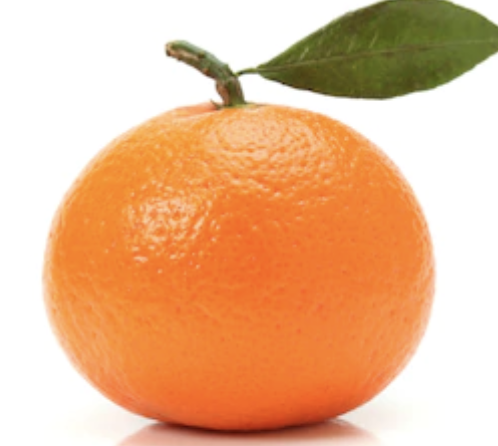

In [12]:
from PIL import Image
filename = '/kaggle/input/original_data_set/freshoranges/Screen Shot 2018-06-12 at 11.50.14 PM.png'
orange_img = Image.open(filename).convert('RGB')
orange_img

In [13]:
import numpy as np

torch.tensor(np.array(orange_img)).shape

torch.Size([446, 498, 3])

In [14]:
torch.tensor(np.array(orange_img)).permute(2, 0, 1).shape

torch.Size([3, 446, 498])

In [15]:
torch.tensor(np.array(orange_img)).permute(2, 0, 1).unsqueeze(0).shape

torch.Size([1, 3, 446, 498])

In [16]:
reshaped_tensor = torch.tensor(np.array(orange_img)).permute(2, 0, 1).unsqueeze(0)

In [17]:
pre_trans(reshaped_tensor).shape

torch.Size([1, 3, 224, 224])

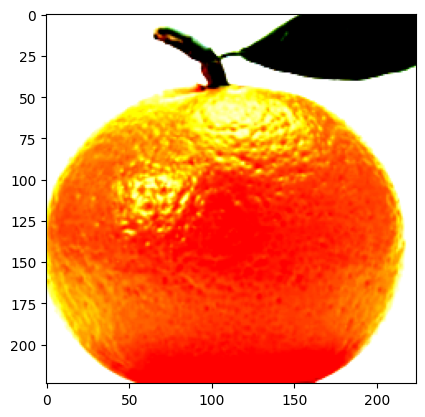

In [18]:
import matplotlib.pyplot as plt

plt.imshow(pre_trans(reshaped_tensor).squeeze().permute(1, 2, 0));

In [19]:
os.listdir(train_dir)

['rottenapples',
 'freshoranges',
 'freshbanana',
 'freshapples',
 'rottenoranges',
 'rottenbanana']

## WandB Login

In [20]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_secret = user_secrets.get_secret("wandb")

In [21]:
import os
# Set your WANDB_API_KEY as an environment variable
os.environ['WANDB_API_KEY'] = wandb_secret

## Datasets and Dataloaders

In [22]:
from torchvision import datasets, transforms
import wandb

# Initialize a new wandb run
#wandb.init(project="resnet18-hyperparam-simple")


# Define transforms for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
data_dir = '/kaggle/working'  # Specify your data directory
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

In [23]:
data_transforms['train']

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [24]:
# Create dataloaders
train_dataloader =  torch.utils.data.DataLoader(image_datasets['train'], batch_size=32,
                                              shuffle=True, num_workers=4)

val_dataloader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=32,
                                              shuffle=False, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=32,
                                              shuffle=False, num_workers=4)

dataloaders = {"train": train_dataloader, "val":val_dataloader, "test":test_dataloader} 

## Training Loop

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

# Initialize wandb
project="'tracking training loop resnet18 apple banana orange'"
# https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-
wandb.init(settings=wandb.Settings(start_method="fork"), project=project)
#wandb.init(project=project)

# Training loop
num_epochs = 5
# We will save the weights of the model with best validation loss
best_val_loss = float('inf')
best_model_weights = my_model.state_dict()

train_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            # Activates BatchNorm and Dropout layers for training stability and data augmentation
            my_model.train()
        else:
            # Turns off BatchNorm and Dropout layers for reproducible outputs
            my_model.eval()

        running_loss = 0.0
        running_correct_predictions = 0.0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = my_model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_correct_predictions += torch.sum(preds == labels.data).item()
            
        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_accuracy = running_correct_predictions / len(image_datasets[phase])
        if phase == 'train':
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)
          
            # Check for the best validation loss
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                # Save the best model
                print("New best model found")
                best_model_weights = my_model.state_dict()
                
        print(f"epoch {epoch} {phase} loss: {epoch_loss:.4f}, accuracy: {epoch_accuracy:.2f}")

        wandb.log({f"{phase}_loss": epoch_loss, f"{phase}_accuracy": epoch_accuracy})

torch.save(best_model_weights, 'best_model.pth')


wandb: Currently logged in as: andandandand (dsr-b33-img-seg). Use `wandb login --relogin` to force relogin


epoch 0 train loss: 1.0284, accuracy: 0.65
New best model found
epoch 0 val loss: 0.2968, accuracy: 0.87
epoch 1 train loss: 0.2882, accuracy: 0.90
New best model found
epoch 1 val loss: 0.1571, accuracy: 0.95
epoch 2 train loss: 0.2511, accuracy: 0.91
epoch 2 val loss: 0.1621, accuracy: 0.95
epoch 3 train loss: 0.2607, accuracy: 0.90
New best model found
epoch 3 val loss: 0.1366, accuracy: 0.95
epoch 4 train loss: 0.1910, accuracy: 0.93
New best model found
epoch 4 val loss: 0.1210, accuracy: 0.95


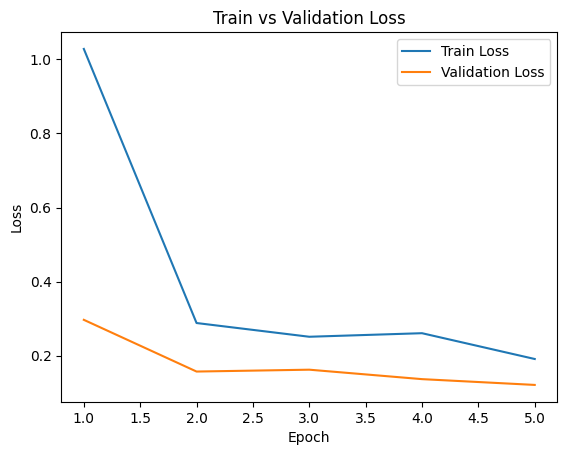

In [26]:
# Plot train vs validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()


In [27]:
import sys
def total_size(obj, seen=None):
    if seen is None:
        seen = set()
        
    obj_id = id(obj)
    if obj_id in seen:
        return 0

    seen.add(obj_id)
    size = sys.getsizeof(obj)

    if isinstance(obj, dict):
        size += sum(total_size(k, seen) for k in obj.keys())
        size += sum(total_size(v, seen) for v in obj.values())
    elif hasattr(obj, '__dict__'):
        size += total_size(vars(obj), seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum(total_size(i, seen) for i in obj)
        
    return size

In [28]:
total_size(best_model_weights)

42570

In [29]:
# Save the model with best validation loss (not necessarily the one at the end of training)
torch.save(best_model_weights, 'model.pth')

model_artifact = wandb.Artifact(
    "resnet18", 
    type="model",
    description="ResNet18 trained on the Apples-Bananas-Oranges dataset"
)
model_artifact.add_file("model.pth")
wandb.save("model.pth")
wandb.log_artifact(model_artifact)
wandb.finish()

train_accuracy,▁▇█▇█
train_loss,█▂▂▂▁
val_accuracy,▁████
val_loss,█▂▃▂▁
train_accuracy,0.93363
train_loss,0.19102
val_accuracy,0.95033
val_loss,0.12101


In [37]:
type(best_model_weights)

collections.OrderedDict

In [42]:
 my_model.load_state_dict(best_model_weights)


<All keys matched successfully>

In [63]:
my_model.eval()
test_loss = 0.0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = my_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [64]:
test_accuracy = correct / total
test_loss = test_loss / len(dataloaders['test'])

print(f'Test Loss: {test_loss:.5f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

Test Loss: 0.14914
Test Accuracy: 0.94
